In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='100-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
INPUT_PT_PATH = f"/workspace/datasets/profiles-v2/profiles-v2-pca-5d/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553/density_plot.png


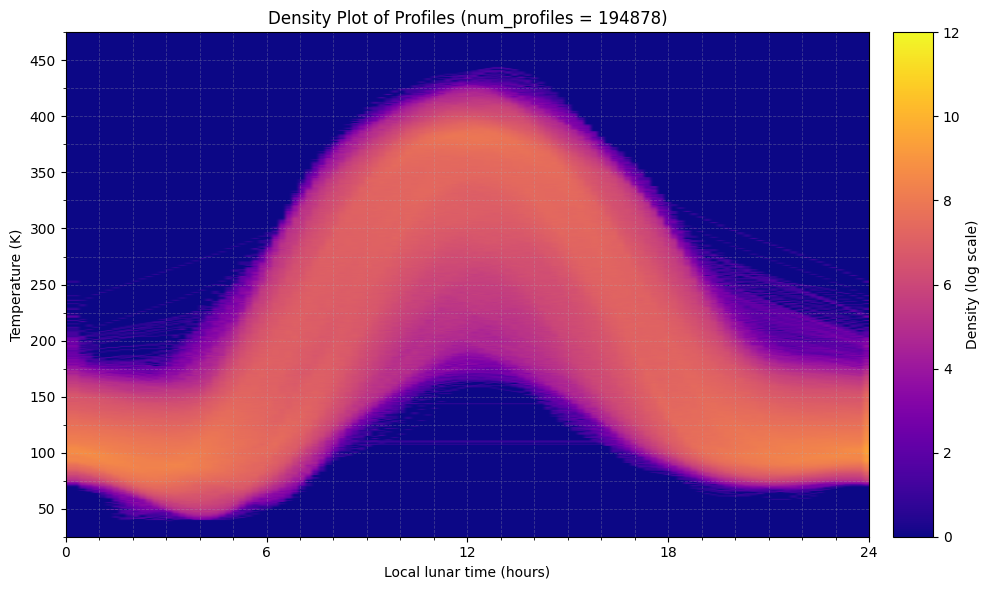

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.2955
STD: 98.3151
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 136414
Validation Data: 38975
Test Data: 19489


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 683/683 [00:20<00:00, 33.32it/s, best_loss=0.6211]


[Training] Epoch 1/100, L1 Loss: 0.6293, L2 Loss: 0.6544, KL Loss: 0.5506, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 195/195 [00:01<00:00, 110.86it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5422, Val L2 Loss: 0.5422, Val KL Loss: 0.6823
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 2/100: 100%|██████████| 683/683 [00:21<00:00, 32.31it/s, best_loss=0.6224]


[Training] Epoch 2/100, L1 Loss: 0.5890, L2 Loss: 0.5957, KL Loss: 0.6495, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 195/195 [00:01<00:00, 108.05it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5518, Val L2 Loss: 0.5501, Val KL Loss: 0.6062


[Training] Epoch 3/100: 100%|██████████| 683/683 [00:21<00:00, 31.70it/s, best_loss=0.6329]


[Training] Epoch 3/100, L1 Loss: 0.5882, L2 Loss: 0.5942, KL Loss: 0.6502, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 195/195 [00:01<00:00, 104.14it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5451, Val L2 Loss: 0.5447, Val KL Loss: 0.6405


[Training] Epoch 4/100: 100%|██████████| 683/683 [00:21<00:00, 31.87it/s, best_loss=0.6396]


[Training] Epoch 4/100, L1 Loss: 0.5876, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 195/195 [00:01<00:00, 104.70it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5432, Val L2 Loss: 0.5430, Val KL Loss: 0.6399


[Training] Epoch 5/100: 100%|██████████| 683/683 [00:21<00:00, 31.99it/s, best_loss=0.6206]


[Training] Epoch 5/100, L1 Loss: 0.5875, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 195/195 [00:01<00:00, 103.69it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5367, Val L2 Loss: 0.5382, Val KL Loss: 0.6558
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 6/100: 100%|██████████| 683/683 [00:21<00:00, 31.88it/s, best_loss=0.6041]


[Training] Epoch 6/100, L1 Loss: 0.5873, L2 Loss: 0.5932, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 195/195 [00:01<00:00, 106.69it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5414, Val L2 Loss: 0.5415, Val KL Loss: 0.6386


[Training] Epoch 7/100: 100%|██████████| 683/683 [00:21<00:00, 31.73it/s, best_loss=0.6082]


[Training] Epoch 7/100, L1 Loss: 0.5872, L2 Loss: 0.5931, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 195/195 [00:01<00:00, 99.50it/s] 


[Validation] Epoch 7/100, Val L1 Loss: 0.5361, Val L2 Loss: 0.5376, Val KL Loss: 0.6566
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 8/100: 100%|██████████| 683/683 [00:21<00:00, 31.74it/s, best_loss=0.6046]


[Training] Epoch 8/100, L1 Loss: 0.5875, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 195/195 [00:01<00:00, 105.93it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5402, Val L2 Loss: 0.5407, Val KL Loss: 0.6517


[Training] Epoch 9/100: 100%|██████████| 683/683 [00:21<00:00, 31.79it/s, best_loss=0.6232]


[Training] Epoch 9/100, L1 Loss: 0.5880, L2 Loss: 0.5941, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 195/195 [00:01<00:00, 112.71it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5368, Val L2 Loss: 0.5378, Val KL Loss: 0.6617


[Training] Epoch 10/100: 100%|██████████| 683/683 [00:21<00:00, 31.73it/s, best_loss=0.5013]


[Training] Epoch 10/100, L1 Loss: 0.5874, L2 Loss: 0.5932, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 195/195 [00:01<00:00, 104.29it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5388, Val L2 Loss: 0.5395, Val KL Loss: 0.6501


[Training] Epoch 11/100: 100%|██████████| 683/683 [00:20<00:00, 32.55it/s, best_loss=0.6135]


[Training] Epoch 11/100, L1 Loss: 0.5876, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 195/195 [00:01<00:00, 120.27it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5392, Val L2 Loss: 0.5397, Val KL Loss: 0.6508


[Training] Epoch 12/100: 100%|██████████| 683/683 [00:20<00:00, 32.68it/s, best_loss=0.5862]


[Training] Epoch 12/100, L1 Loss: 0.5873, L2 Loss: 0.5932, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 195/195 [00:01<00:00, 103.58it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5404, Val L2 Loss: 0.5409, Val KL Loss: 0.6436


[Training] Epoch 13/100: 100%|██████████| 683/683 [00:20<00:00, 33.64it/s, best_loss=0.6215]


[Training] Epoch 13/100, L1 Loss: 0.5875, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 195/195 [00:01<00:00, 112.95it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5419, Val KL Loss: 0.6396


[Training] Epoch 14/100: 100%|██████████| 683/683 [00:20<00:00, 32.98it/s, best_loss=0.5967]


[Training] Epoch 14/100, L1 Loss: 0.5879, L2 Loss: 0.5943, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 195/195 [00:01<00:00, 109.59it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5361, Val L2 Loss: 0.5375, Val KL Loss: 0.6580


[Training] Epoch 15/100: 100%|██████████| 683/683 [00:20<00:00, 33.07it/s, best_loss=0.6126]


[Training] Epoch 15/100, L1 Loss: 0.5877, L2 Loss: 0.5939, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 195/195 [00:01<00:00, 105.85it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5368, Val L2 Loss: 0.5380, Val KL Loss: 0.6625


[Training] Epoch 16/100: 100%|██████████| 683/683 [00:20<00:00, 33.63it/s, best_loss=0.6257]


[Training] Epoch 16/100, L1 Loss: 0.5875, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 195/195 [00:01<00:00, 108.69it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5446, Val KL Loss: 0.6449


[Training] Epoch 17/100: 100%|██████████| 683/683 [00:20<00:00, 33.37it/s, best_loss=0.6148]


[Training] Epoch 17/100, L1 Loss: 0.5876, L2 Loss: 0.5938, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 195/195 [00:01<00:00, 113.18it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5458, Val L2 Loss: 0.5452, Val KL Loss: 0.6396


[Training] Epoch 18/100: 100%|██████████| 683/683 [00:20<00:00, 32.97it/s, best_loss=0.6309]


[Training] Epoch 18/100, L1 Loss: 0.5879, L2 Loss: 0.5942, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 195/195 [00:01<00:00, 123.50it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5402, Val KL Loss: 0.6448


[Training] Epoch 19/100: 100%|██████████| 683/683 [00:20<00:00, 33.19it/s, best_loss=0.5910]


[Training] Epoch 19/100, L1 Loss: 0.5876, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 195/195 [00:01<00:00, 107.77it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5386, Val L2 Loss: 0.5396, Val KL Loss: 0.6550


[Training] Epoch 20/100: 100%|██████████| 683/683 [00:20<00:00, 33.36it/s, best_loss=0.6150]


[Training] Epoch 20/100, L1 Loss: 0.5873, L2 Loss: 0.5932, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 195/195 [00:01<00:00, 121.13it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5423, Val L2 Loss: 0.5423, Val KL Loss: 0.6446


[Training] Epoch 21/100: 100%|██████████| 683/683 [00:21<00:00, 31.71it/s, best_loss=0.6090]


[Training] Epoch 21/100, L1 Loss: 0.5878, L2 Loss: 0.5938, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 195/195 [00:01<00:00, 110.11it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5395, Val L2 Loss: 0.5401, Val KL Loss: 0.6452


[Training] Epoch 22/100: 100%|██████████| 683/683 [00:20<00:00, 33.12it/s, best_loss=0.6362]


[Training] Epoch 22/100, L1 Loss: 0.5878, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 195/195 [00:01<00:00, 112.71it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5429, Val L2 Loss: 0.5428, Val KL Loss: 0.6383


[Training] Epoch 23/100: 100%|██████████| 683/683 [00:20<00:00, 33.90it/s, best_loss=0.6143]


[Training] Epoch 23/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 195/195 [00:01<00:00, 113.36it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5364, Val KL Loss: 0.6633
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 24/100: 100%|██████████| 683/683 [00:21<00:00, 32.02it/s, best_loss=0.6243]


[Training] Epoch 24/100, L1 Loss: 0.5877, L2 Loss: 0.5936, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 195/195 [00:01<00:00, 99.28it/s] 


[Validation] Epoch 24/100, Val L1 Loss: 0.5403, Val L2 Loss: 0.5406, Val KL Loss: 0.6455


[Training] Epoch 25/100: 100%|██████████| 683/683 [00:21<00:00, 31.14it/s, best_loss=0.6222]


[Training] Epoch 25/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 195/195 [00:01<00:00, 97.55it/s] 


[Validation] Epoch 25/100, Val L1 Loss: 0.5380, Val L2 Loss: 0.5389, Val KL Loss: 0.6564


[Training] Epoch 26/100: 100%|██████████| 683/683 [00:21<00:00, 31.31it/s, best_loss=0.6224]


[Training] Epoch 26/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 195/195 [00:02<00:00, 97.19it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5428, Val L2 Loss: 0.5429, Val KL Loss: 0.6415


[Training] Epoch 27/100: 100%|██████████| 683/683 [00:22<00:00, 31.01it/s, best_loss=0.5997]


[Training] Epoch 27/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 195/195 [00:02<00:00, 92.09it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5452, Val L2 Loss: 0.5444, Val KL Loss: 0.6415


[Training] Epoch 28/100: 100%|██████████| 683/683 [00:21<00:00, 31.57it/s, best_loss=0.6255]


[Training] Epoch 28/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 195/195 [00:02<00:00, 95.86it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5391, Val KL Loss: 0.6568


[Training] Epoch 29/100: 100%|██████████| 683/683 [00:22<00:00, 30.80it/s, best_loss=0.6282]


[Training] Epoch 29/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 195/195 [00:01<00:00, 105.74it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5387, Val L2 Loss: 0.5395, Val KL Loss: 0.6491


[Training] Epoch 30/100: 100%|██████████| 683/683 [00:22<00:00, 30.59it/s, best_loss=0.5749]


[Training] Epoch 30/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 195/195 [00:01<00:00, 98.75it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5360, Val KL Loss: 0.6583
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 31/100: 100%|██████████| 683/683 [00:21<00:00, 31.14it/s, best_loss=0.6220]


[Training] Epoch 31/100, L1 Loss: 0.5879, L2 Loss: 0.5939, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 195/195 [00:02<00:00, 93.95it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5378, Val KL Loss: 0.6563


[Training] Epoch 32/100: 100%|██████████| 683/683 [00:21<00:00, 31.26it/s, best_loss=0.6039]


[Training] Epoch 32/100, L1 Loss: 0.5877, L2 Loss: 0.5936, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 195/195 [00:02<00:00, 94.45it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5414, Val KL Loss: 0.6409


[Training] Epoch 33/100: 100%|██████████| 683/683 [00:22<00:00, 30.91it/s, best_loss=0.6153]


[Training] Epoch 33/100, L1 Loss: 0.5874, L2 Loss: 0.5933, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 195/195 [00:02<00:00, 89.87it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5393, Val L2 Loss: 0.5401, Val KL Loss: 0.6513


[Training] Epoch 34/100: 100%|██████████| 683/683 [00:22<00:00, 30.46it/s, best_loss=0.6205]


[Training] Epoch 34/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 195/195 [00:02<00:00, 93.99it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5458, Val L2 Loss: 0.5454, Val KL Loss: 0.6395


[Training] Epoch 35/100: 100%|██████████| 683/683 [00:21<00:00, 31.32it/s, best_loss=0.6009]


[Training] Epoch 35/100, L1 Loss: 0.5880, L2 Loss: 0.5939, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 195/195 [00:01<00:00, 103.27it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5436, Val L2 Loss: 0.5438, Val KL Loss: 0.6453


[Training] Epoch 36/100: 100%|██████████| 683/683 [00:22<00:00, 30.14it/s, best_loss=0.6187]


[Training] Epoch 36/100, L1 Loss: 0.5873, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 195/195 [00:01<00:00, 101.68it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5427, Val L2 Loss: 0.5425, Val KL Loss: 0.6453


[Training] Epoch 37/100: 100%|██████████| 683/683 [00:22<00:00, 30.70it/s, best_loss=0.6227]


[Training] Epoch 37/100, L1 Loss: 0.5872, L2 Loss: 0.5930, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 195/195 [00:02<00:00, 96.57it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5421, Val L2 Loss: 0.5420, Val KL Loss: 0.6440


[Training] Epoch 38/100: 100%|██████████| 683/683 [00:21<00:00, 31.27it/s, best_loss=0.6045]


[Training] Epoch 38/100, L1 Loss: 0.5877, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 195/195 [00:02<00:00, 90.13it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5407, Val L2 Loss: 0.5409, Val KL Loss: 0.6440


[Training] Epoch 39/100: 100%|██████████| 683/683 [00:22<00:00, 30.59it/s, best_loss=0.6073]


[Training] Epoch 39/100, L1 Loss: 0.5877, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 195/195 [00:01<00:00, 97.96it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5441, Val KL Loss: 0.6432


[Training] Epoch 40/100: 100%|██████████| 683/683 [00:22<00:00, 30.94it/s, best_loss=0.6075]


[Training] Epoch 40/100, L1 Loss: 0.5877, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 195/195 [00:02<00:00, 95.11it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5424, Val L2 Loss: 0.5423, Val KL Loss: 0.6419


[Training] Epoch 41/100: 100%|██████████| 683/683 [00:22<00:00, 30.71it/s, best_loss=0.6124]


[Training] Epoch 41/100, L1 Loss: 0.5878, L2 Loss: 0.5939, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 195/195 [00:02<00:00, 87.81it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5416, Val L2 Loss: 0.5416, Val KL Loss: 0.6392


[Training] Epoch 42/100: 100%|██████████| 683/683 [00:22<00:00, 30.69it/s, best_loss=0.6176]


[Training] Epoch 42/100, L1 Loss: 0.5879, L2 Loss: 0.5942, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 195/195 [00:02<00:00, 91.10it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5400, Val L2 Loss: 0.5411, Val KL Loss: 0.6502


[Training] Epoch 43/100: 100%|██████████| 683/683 [00:22<00:00, 30.51it/s, best_loss=0.6227]


[Training] Epoch 43/100, L1 Loss: 0.5877, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 195/195 [00:01<00:00, 99.49it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5433, Val L2 Loss: 0.5432, Val KL Loss: 0.6423


[Training] Epoch 44/100: 100%|██████████| 683/683 [00:22<00:00, 30.57it/s, best_loss=0.6148]


[Training] Epoch 44/100, L1 Loss: 0.5876, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 195/195 [00:01<00:00, 99.93it/s] 


[Validation] Epoch 44/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5438, Val KL Loss: 0.6383


[Training] Epoch 45/100: 100%|██████████| 683/683 [00:22<00:00, 30.54it/s, best_loss=0.5831]


[Training] Epoch 45/100, L1 Loss: 0.5879, L2 Loss: 0.5941, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 195/195 [00:02<00:00, 89.38it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5431, Val L2 Loss: 0.5427, Val KL Loss: 0.6385


[Training] Epoch 46/100: 100%|██████████| 683/683 [00:23<00:00, 29.60it/s, best_loss=0.6018]


[Training] Epoch 46/100, L1 Loss: 0.5872, L2 Loss: 0.5933, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 195/195 [00:02<00:00, 96.21it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.5430, Val L2 Loss: 0.5424, Val KL Loss: 0.6431


[Training] Epoch 47/100: 100%|██████████| 683/683 [00:22<00:00, 30.76it/s, best_loss=0.6339]


[Training] Epoch 47/100, L1 Loss: 0.5877, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 195/195 [00:02<00:00, 92.95it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5450, Val L2 Loss: 0.5446, Val KL Loss: 0.6354


[Training] Epoch 48/100: 100%|██████████| 683/683 [00:21<00:00, 31.09it/s, best_loss=0.6295]


[Training] Epoch 48/100, L1 Loss: 0.5876, L2 Loss: 0.5938, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 195/195 [00:02<00:00, 93.00it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5349, Val L2 Loss: 0.5368, Val KL Loss: 0.6567


[Training] Epoch 49/100: 100%|██████████| 683/683 [00:22<00:00, 30.88it/s, best_loss=0.6157]


[Training] Epoch 49/100, L1 Loss: 0.5876, L2 Loss: 0.5937, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 195/195 [00:01<00:00, 100.97it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5367, Val KL Loss: 0.6650


[Training] Epoch 50/100: 100%|██████████| 683/683 [00:22<00:00, 30.27it/s, best_loss=0.6117]


[Training] Epoch 50/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 195/195 [00:02<00:00, 95.63it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5387, Val KL Loss: 0.6526


[Training] Epoch 51/100: 100%|██████████| 683/683 [00:22<00:00, 30.86it/s, best_loss=0.6196]


[Training] Epoch 51/100, L1 Loss: 0.5879, L2 Loss: 0.5939, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 195/195 [00:02<00:00, 96.75it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5379, Val L2 Loss: 0.5391, Val KL Loss: 0.6529


[Training] Epoch 52/100: 100%|██████████| 683/683 [00:22<00:00, 30.41it/s, best_loss=0.6298]


[Training] Epoch 52/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 195/195 [00:01<00:00, 113.09it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5432, Val L2 Loss: 0.5429, Val KL Loss: 0.6410


[Training] Epoch 53/100: 100%|██████████| 683/683 [00:22<00:00, 30.73it/s, best_loss=0.5910]


[Training] Epoch 53/100, L1 Loss: 0.5883, L2 Loss: 0.5951, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 195/195 [00:02<00:00, 91.82it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5342, Val KL Loss: 0.6708
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_100-5d_20250803_1553'


[Training] Epoch 54/100: 100%|██████████| 683/683 [00:22<00:00, 30.33it/s, best_loss=0.5742]


[Training] Epoch 54/100, L1 Loss: 0.5878, L2 Loss: 0.5937, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 195/195 [00:02<00:00, 86.61it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5376, Val L2 Loss: 0.5388, Val KL Loss: 0.6519


[Training] Epoch 55/100: 100%|██████████| 683/683 [00:22<00:00, 29.89it/s, best_loss=0.6133]


[Training] Epoch 55/100, L1 Loss: 0.5874, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 195/195 [00:02<00:00, 85.97it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5452, Val L2 Loss: 0.5447, Val KL Loss: 0.6352


[Training] Epoch 56/100: 100%|██████████| 683/683 [00:22<00:00, 29.79it/s, best_loss=0.6100]


[Training] Epoch 56/100, L1 Loss: 0.5878, L2 Loss: 0.5939, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 195/195 [00:01<00:00, 99.84it/s] 


[Validation] Epoch 56/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5403, Val KL Loss: 0.6491


[Training] Epoch 57/100: 100%|██████████| 683/683 [00:22<00:00, 30.90it/s, best_loss=0.5142]


[Training] Epoch 57/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 195/195 [00:02<00:00, 93.94it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5426, Val L2 Loss: 0.5425, Val KL Loss: 0.6437


[Training] Epoch 58/100: 100%|██████████| 683/683 [00:22<00:00, 30.22it/s, best_loss=0.5858]


[Training] Epoch 58/100, L1 Loss: 0.5874, L2 Loss: 0.5931, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 195/195 [00:01<00:00, 99.85it/s] 


[Validation] Epoch 58/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5389, Val KL Loss: 0.6609


[Training] Epoch 59/100: 100%|██████████| 683/683 [00:22<00:00, 31.04it/s, best_loss=0.6259]


[Training] Epoch 59/100, L1 Loss: 0.5877, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 195/195 [00:02<00:00, 89.97it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5388, Val L2 Loss: 0.5398, Val KL Loss: 0.6432


[Training] Epoch 60/100: 100%|██████████| 683/683 [00:22<00:00, 30.76it/s, best_loss=0.6267]


[Training] Epoch 60/100, L1 Loss: 0.5877, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 195/195 [00:02<00:00, 79.43it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5390, Val L2 Loss: 0.5397, Val KL Loss: 0.6519


[Training] Epoch 61/100: 100%|██████████| 683/683 [00:22<00:00, 30.98it/s, best_loss=0.6001]


[Training] Epoch 61/100, L1 Loss: 0.5877, L2 Loss: 0.5940, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 195/195 [00:02<00:00, 86.92it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5437, Val L2 Loss: 0.5430, Val KL Loss: 0.6452


[Training] Epoch 62/100: 100%|██████████| 683/683 [00:22<00:00, 30.42it/s, best_loss=0.6182]


[Training] Epoch 62/100, L1 Loss: 0.5877, L2 Loss: 0.5939, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 195/195 [00:02<00:00, 87.30it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5403, Val L2 Loss: 0.5405, Val KL Loss: 0.6399


[Training] Epoch 63/100: 100%|██████████| 683/683 [00:22<00:00, 30.36it/s, best_loss=0.5947]


[Training] Epoch 63/100, L1 Loss: 0.5871, L2 Loss: 0.5930, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 195/195 [00:02<00:00, 96.20it/s] 


[Validation] Epoch 63/100, Val L1 Loss: 0.5410, Val L2 Loss: 0.5411, Val KL Loss: 0.6506


[Training] Epoch 64/100: 100%|██████████| 683/683 [00:22<00:00, 30.74it/s, best_loss=0.5895]


[Training] Epoch 64/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 195/195 [00:02<00:00, 93.49it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5428, Val L2 Loss: 0.5430, Val KL Loss: 0.6433


[Training] Epoch 65/100: 100%|██████████| 683/683 [00:22<00:00, 30.63it/s, best_loss=0.6219]


[Training] Epoch 65/100, L1 Loss: 0.5875, L2 Loss: 0.5937, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 195/195 [00:01<00:00, 102.45it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5462, Val L2 Loss: 0.5455, Val KL Loss: 0.6409


[Training] Epoch 66/100: 100%|██████████| 683/683 [00:22<00:00, 30.57it/s, best_loss=0.6174]


[Training] Epoch 66/100, L1 Loss: 0.5878, L2 Loss: 0.5936, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 195/195 [00:02<00:00, 95.33it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5422, Val L2 Loss: 0.5419, Val KL Loss: 0.6431


[Training] Epoch 67/100: 100%|██████████| 683/683 [00:22<00:00, 30.71it/s, best_loss=0.5677]


[Training] Epoch 67/100, L1 Loss: 0.5876, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 195/195 [00:02<00:00, 93.32it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5420, Val L2 Loss: 0.5422, Val KL Loss: 0.6447


[Training] Epoch 68/100: 100%|██████████| 683/683 [00:22<00:00, 30.27it/s, best_loss=0.6110]


[Training] Epoch 68/100, L1 Loss: 0.5877, L2 Loss: 0.5938, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 195/195 [00:01<00:00, 103.87it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5431, Val L2 Loss: 0.5426, Val KL Loss: 0.6405


[Training] Epoch 69/100: 100%|██████████| 683/683 [00:22<00:00, 30.96it/s, best_loss=0.5760]


[Training] Epoch 69/100, L1 Loss: 0.5873, L2 Loss: 0.5933, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 195/195 [00:02<00:00, 89.67it/s] 


[Validation] Epoch 69/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5394, Val KL Loss: 0.6504


[Training] Epoch 70/100: 100%|██████████| 683/683 [00:22<00:00, 30.32it/s, best_loss=0.6345]


[Training] Epoch 70/100, L1 Loss: 0.5877, L2 Loss: 0.5935, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 195/195 [00:01<00:00, 102.57it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5379, Val L2 Loss: 0.5388, Val KL Loss: 0.6555


[Training] Epoch 71/100: 100%|██████████| 683/683 [00:22<00:00, 29.80it/s, best_loss=0.5981]


[Training] Epoch 71/100, L1 Loss: 0.5876, L2 Loss: 0.5937, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 195/195 [00:02<00:00, 91.49it/s] 


[Validation] Epoch 71/100, Val L1 Loss: 0.5318, Val L2 Loss: 0.5344, Val KL Loss: 0.6675


[Training] Epoch 72/100: 100%|██████████| 683/683 [00:22<00:00, 30.41it/s, best_loss=0.6330]


[Training] Epoch 72/100, L1 Loss: 0.5875, L2 Loss: 0.5935, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 195/195 [00:01<00:00, 100.67it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5359, Val L2 Loss: 0.5376, Val KL Loss: 0.6613


[Training] Epoch 73/100: 100%|██████████| 683/683 [00:22<00:00, 30.68it/s, best_loss=0.6098]


[Training] Epoch 73/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 195/195 [00:02<00:00, 91.40it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5409, Val L2 Loss: 0.5412, Val KL Loss: 0.6447


[Training] Epoch 74/100: 100%|██████████| 683/683 [00:22<00:00, 30.61it/s, best_loss=0.6101]


[Training] Epoch 74/100, L1 Loss: 0.5877, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 195/195 [00:02<00:00, 88.47it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5400, Val L2 Loss: 0.5405, Val KL Loss: 0.6489


[Training] Epoch 75/100: 100%|██████████| 683/683 [00:22<00:00, 30.39it/s, best_loss=0.6033]


[Training] Epoch 75/100, L1 Loss: 0.5875, L2 Loss: 0.5935, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 195/195 [00:02<00:00, 94.48it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5392, Val KL Loss: 0.6472


[Training] Epoch 76/100: 100%|██████████| 683/683 [00:22<00:00, 30.25it/s, best_loss=0.5839]


[Training] Epoch 76/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 195/195 [00:02<00:00, 88.50it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5480, Val L2 Loss: 0.5471, Val KL Loss: 0.6397


[Training] Epoch 77/100: 100%|██████████| 683/683 [00:22<00:00, 30.77it/s, best_loss=0.6086]


[Training] Epoch 77/100, L1 Loss: 0.5878, L2 Loss: 0.5939, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 195/195 [00:02<00:00, 82.79it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5377, Val L2 Loss: 0.5392, Val KL Loss: 0.6491


[Training] Epoch 78/100: 100%|██████████| 683/683 [00:22<00:00, 30.46it/s, best_loss=0.6238]


[Training] Epoch 78/100, L1 Loss: 0.5877, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 195/195 [00:02<00:00, 91.05it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5353, Val L2 Loss: 0.5369, Val KL Loss: 0.6557


[Training] Epoch 79/100: 100%|██████████| 683/683 [00:21<00:00, 31.38it/s, best_loss=0.6145]


[Training] Epoch 79/100, L1 Loss: 0.5877, L2 Loss: 0.5939, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 195/195 [00:02<00:00, 94.53it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5429, Val L2 Loss: 0.5428, Val KL Loss: 0.6448


[Training] Epoch 80/100: 100%|██████████| 683/683 [00:22<00:00, 30.63it/s, best_loss=0.6079]


[Training] Epoch 80/100, L1 Loss: 0.5874, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 195/195 [00:01<00:00, 102.78it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5415, Val KL Loss: 0.6479


[Training] Epoch 81/100: 100%|██████████| 683/683 [00:22<00:00, 30.60it/s, best_loss=0.6243]


[Training] Epoch 81/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 195/195 [00:02<00:00, 94.93it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5400, Val L2 Loss: 0.5401, Val KL Loss: 0.6426


[Training] Epoch 82/100: 100%|██████████| 683/683 [00:22<00:00, 30.56it/s, best_loss=0.5137]


[Training] Epoch 82/100, L1 Loss: 0.5874, L2 Loss: 0.5933, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 195/195 [00:02<00:00, 95.35it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5398, Val L2 Loss: 0.5405, Val KL Loss: 0.6521


[Training] Epoch 83/100: 100%|██████████| 683/683 [00:23<00:00, 28.87it/s, best_loss=0.6224]


[Training] Epoch 83/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 195/195 [00:02<00:00, 92.11it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5374, Val L2 Loss: 0.5387, Val KL Loss: 0.6539


[Training] Epoch 84/100: 100%|██████████| 683/683 [00:22<00:00, 30.85it/s, best_loss=0.6086]


[Training] Epoch 84/100, L1 Loss: 0.5877, L2 Loss: 0.5937, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 195/195 [00:02<00:00, 93.95it/s] 


[Validation] Epoch 84/100, Val L1 Loss: 0.5401, Val L2 Loss: 0.5405, Val KL Loss: 0.6477


[Training] Epoch 85/100: 100%|██████████| 683/683 [00:22<00:00, 30.24it/s, best_loss=0.6026]


[Training] Epoch 85/100, L1 Loss: 0.5877, L2 Loss: 0.5939, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 195/195 [00:02<00:00, 94.10it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5386, Val L2 Loss: 0.5394, Val KL Loss: 0.6443


[Training] Epoch 86/100: 100%|██████████| 683/683 [00:21<00:00, 31.20it/s, best_loss=0.6221]


[Training] Epoch 86/100, L1 Loss: 0.5875, L2 Loss: 0.5933, KL Loss: 0.6522, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 195/195 [00:02<00:00, 93.54it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5362, Val L2 Loss: 0.5374, Val KL Loss: 0.6605


[Training] Epoch 87/100: 100%|██████████| 683/683 [00:22<00:00, 30.28it/s, best_loss=0.5782]


[Training] Epoch 87/100, L1 Loss: 0.5874, L2 Loss: 0.5934, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 195/195 [00:02<00:00, 88.17it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5414, Val L2 Loss: 0.5413, Val KL Loss: 0.6468


[Training] Epoch 88/100: 100%|██████████| 683/683 [00:22<00:00, 30.46it/s, best_loss=0.5791]


[Training] Epoch 88/100, L1 Loss: 0.5874, L2 Loss: 0.5932, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 195/195 [00:02<00:00, 87.80it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5453, Val L2 Loss: 0.5445, Val KL Loss: 0.6406


[Training] Epoch 89/100: 100%|██████████| 683/683 [00:22<00:00, 30.50it/s, best_loss=0.6112]


[Training] Epoch 89/100, L1 Loss: 0.5879, L2 Loss: 0.5943, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 195/195 [00:02<00:00, 87.49it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5408, Val L2 Loss: 0.5410, Val KL Loss: 0.6527


[Training] Epoch 90/100: 100%|██████████| 683/683 [00:22<00:00, 30.98it/s, best_loss=0.6073]


[Training] Epoch 90/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 195/195 [00:01<00:00, 101.71it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5432, Val L2 Loss: 0.5428, Val KL Loss: 0.6396


[Training] Epoch 91/100: 100%|██████████| 683/683 [00:22<00:00, 30.42it/s, best_loss=0.5588]


[Training] Epoch 91/100, L1 Loss: 0.5874, L2 Loss: 0.5931, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 195/195 [00:02<00:00, 83.02it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5426, Val L2 Loss: 0.5427, Val KL Loss: 0.6427


[Training] Epoch 92/100: 100%|██████████| 683/683 [00:22<00:00, 30.41it/s, best_loss=0.6214]


[Training] Epoch 92/100, L1 Loss: 0.5876, L2 Loss: 0.5937, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 195/195 [00:02<00:00, 93.97it/s] 


[Validation] Epoch 92/100, Val L1 Loss: 0.5404, Val L2 Loss: 0.5408, Val KL Loss: 0.6605


[Training] Epoch 93/100: 100%|██████████| 683/683 [00:22<00:00, 30.70it/s, best_loss=0.6301]


[Training] Epoch 93/100, L1 Loss: 0.5876, L2 Loss: 0.5940, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 195/195 [00:02<00:00, 94.38it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5394, Val KL Loss: 0.6511


[Training] Epoch 94/100: 100%|██████████| 683/683 [00:22<00:00, 30.62it/s, best_loss=0.5674]


[Training] Epoch 94/100, L1 Loss: 0.5873, L2 Loss: 0.5932, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 195/195 [00:01<00:00, 99.25it/s] 


[Validation] Epoch 94/100, Val L1 Loss: 0.5461, Val L2 Loss: 0.5452, Val KL Loss: 0.6397


[Training] Epoch 95/100: 100%|██████████| 683/683 [00:22<00:00, 30.12it/s, best_loss=0.6086]


[Training] Epoch 95/100, L1 Loss: 0.5876, L2 Loss: 0.5938, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 195/195 [00:01<00:00, 106.20it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5512, Val L2 Loss: 0.5494, Val KL Loss: 0.6213


[Training] Epoch 96/100: 100%|██████████| 683/683 [00:22<00:00, 30.73it/s, best_loss=0.6069]


[Training] Epoch 96/100, L1 Loss: 0.5877, L2 Loss: 0.5939, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 195/195 [00:02<00:00, 80.69it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5398, Val KL Loss: 0.6475


[Training] Epoch 97/100: 100%|██████████| 683/683 [00:22<00:00, 30.68it/s, best_loss=0.6257]


[Training] Epoch 97/100, L1 Loss: 0.5875, L2 Loss: 0.5936, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 195/195 [00:02<00:00, 88.19it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5370, Val L2 Loss: 0.5380, Val KL Loss: 0.6559


[Training] Epoch 98/100: 100%|██████████| 683/683 [00:22<00:00, 30.81it/s, best_loss=0.6100]


[Training] Epoch 98/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 195/195 [00:02<00:00, 93.09it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5414, Val L2 Loss: 0.5416, Val KL Loss: 0.6379


[Training] Epoch 99/100: 100%|██████████| 683/683 [00:22<00:00, 30.71it/s, best_loss=0.5890]


[Training] Epoch 99/100, L1 Loss: 0.5876, L2 Loss: 0.5936, KL Loss: 0.6521, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 195/195 [00:02<00:00, 86.94it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5391, Val KL Loss: 0.6547


[Training] Epoch 100/100: 100%|██████████| 683/683 [00:22<00:00, 29.86it/s, best_loss=0.5450]


[Training] Epoch 100/100, L1 Loss: 0.5876, L2 Loss: 0.5934, KL Loss: 0.6520, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 195/195 [00:01<00:00, 97.53it/s] 


[Validation] Epoch 100/100, Val L1 Loss: 0.5422, Val L2 Loss: 0.5422, Val KL Loss: 0.6429


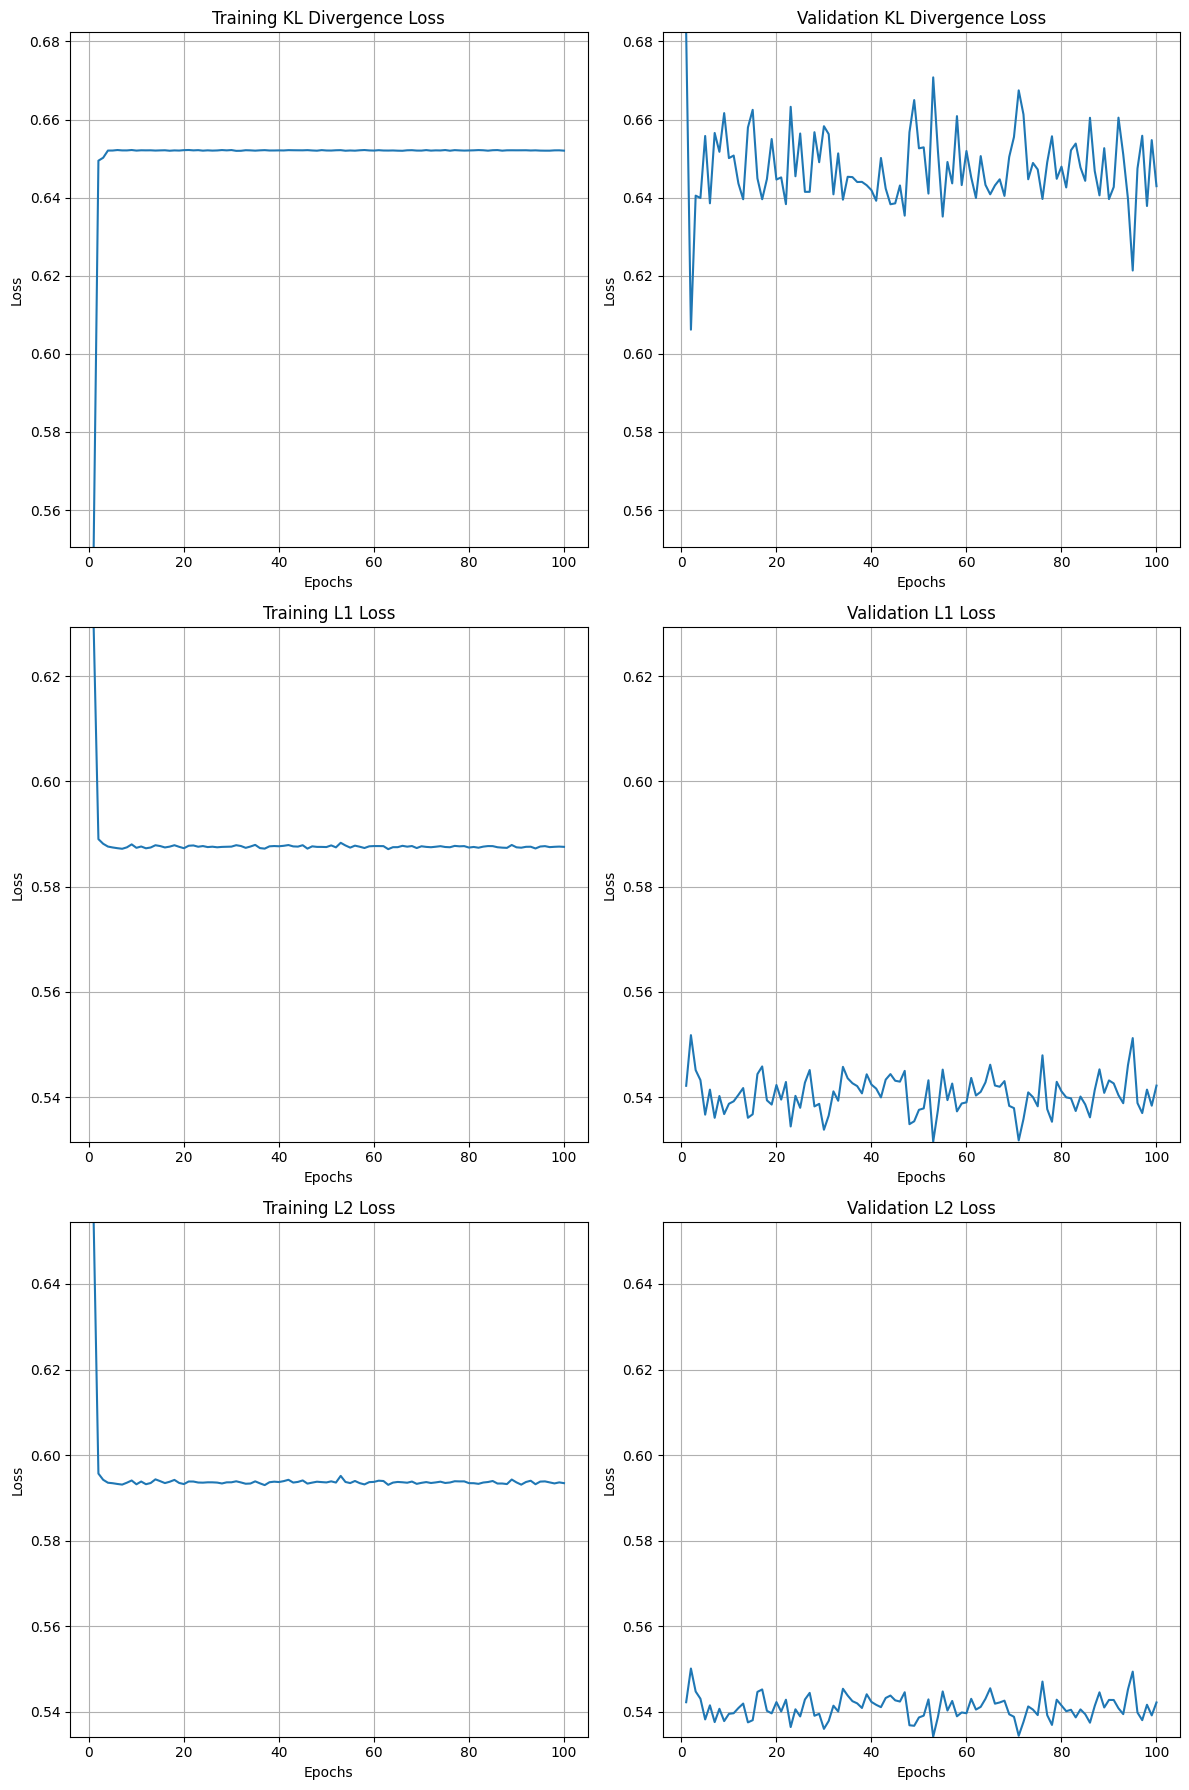

Best Validation Loss in Kelvins:
52.2583 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


z0: -0.0002
z1: 0.0165
z2: -0.0329
z3: 0.0000


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 746.84it/s]


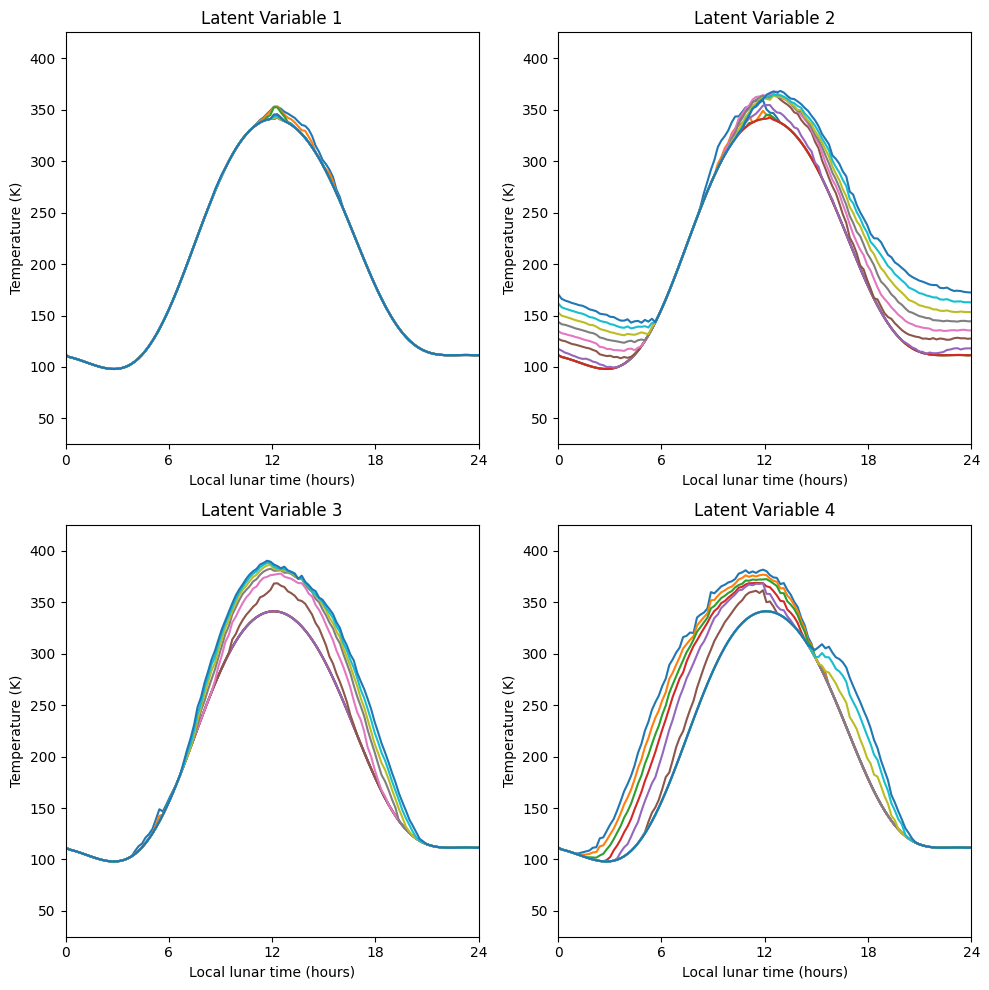

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)